**<h1><center>TWEBOT</center></h1>**

In [60]:
# to print all output for a cell instead of only last one 
import sys

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
sys.path.insert(0, "..")

In [62]:
import os
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import utils_analytics as ut
from IPython.display import Image
from nltk.corpus import stopwords
from pandas.core.common import flatten
from sklearn.ensemble import RandomForestClassifier

from src.process import process_account_dataset


## **Introduction**
For this project we decided to focus on data. Our goal was to understand what kind of information is needed to accurately discriminate bot from humans on the Twitter social media platform. To do this we decided to feed our models more and more data from multiple sources to discover what piece of information works best for this task. 

We used (nearly) the same model at all steps, with increasingly more data to learn from: 
- the text from only one tweet per user 
- the text from one tweet + custom metadata features on that tweet 
- the text from multiple tweets + custom statistical features on the aggregated tweets
- all the above + custom features from the user account information 

As we can see we started from the simple text of a single tweet. In fact, given the same pool of users, a tweet-based bot detection approach would have significantly more labeled examples to exploit at training time, and would be much faster and flexible when actually deployed. However, prior results in bot detection suggested that tweet text alone is not highly predictive of bot accounts and many works on account-level classification have found that user metadata tends to be the best predictor for bot detection. 

In this project we tackle both account-level bot detection and tweet-level bot detection, with a custom DL model based on LSTM. Moreover, given the tabular nature of the metadata features, and with a view to achieve better model efficiency and interpretability, we also decided to test the performance of a Random Forest classifier on the detection task.

## **The data**

We decided to use the TwiBot-20 dataset which is one of the best in terms of user diversity, user information and number of data points. Before 2022 it was the largest twitter bot detection benchmark, featuring 15K users and 2M tweets. For every user in the dataset, its first 200 tweets are also stored. 

The data contained in it, especially the tweet text, is very raw. For this reason we decided to preprocess it in order for it to be more suitable to be used with a LSTM model. This was also definitely needed to reduce the number of Out Of Vocabulary words which were not included in the embedding model of our choice (we’ll see it later), since tweets contain hashtags, symbols, foreing words, urls, user mentions, etc. 

Here is an example of a raw tweet text:

In [63]:
tweets_df, account_df = ut.loadData()
print(tweets_df.loc[9,'tweet'])

We did it! The first ever #SHAQvsGRONK had over 9 MILLION live viewers who helped @GRONK and I raise money for the @NAACP and @BGCCAN with 1.25 million meals donated to @FeedingAmerica. A big shoutout to @TheGeneralAuto and everyone who performed. Watch this  👀 (🎥: @lanreako) https://t.co/sf7EVKjROT



In [71]:
from nltk.tokenize import TweetTokenizer
import re
import pandas as pd

def process_dataset_v1(dataframe : pd.DataFrame , save_path ) :

    tk = TweetTokenizer(reduce_len=True,preserve_case=False)

    RETWEET = r"^RT (?:@[\w_]+):"
    NEWLINE = r"\n"
    CASHTAG = r"(?<!\S)\$[A-Z]+(?:\.[A-Z]+)?(?!\S)"
    EMAIL = r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]"""
    MONEY = r"[$£][0-9]+(?:[.,]\d+)?[Kk+BM]?|[0-9]+(?:[.,]\d+)?[Kk+BM]?[$£]"
    NUMBER = r"""(?<!\S)(?:[+\-]?\d+(?:%|(?:[,/.:-]\d+[+\-]?)?))"""
    HASHTAG = r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    HANDLE = r"""(?:@[\w_]+)"""

    TO_REPLACE = [RETWEET, NEWLINE, CASHTAG, EMAIL, MONEY, NUMBER, HASHTAG, HANDLE]
    REPLACE_WITH = [' retweet ',' ',' stock ',' email ',' money ',' number ',' hashtag ',' username ']

    def further_process(sentence: str):

        #replace urls 
        sentence = re.sub(r'http\S+|www.\S+', ' url ', sentence)

        #tokenize
        sentence = tk.tokenize(sentence)

        #remove empty strings 
        sentence = [word for word in sentence if word != '']
                
        return sentence

    dataframe['processed_tweet'] = dataframe['tweet'].replace(TO_REPLACE,REPLACE_WITH,regex=True,inplace=False)
    dataframe['processed_tweet'] = dataframe['processed_tweet'].apply(further_process)

    dataframe = dataframe[dataframe['processed_tweet'].map(lambda x: len(x)) > 2].reset_index(drop=True)

    dataframe['label'] = dataframe['label'].astype(float)  

    print('saving processed dataset to file')
    dataframe.to_pickle(save_path)   #save to file 
    
    return dataframe

In [73]:
# Process the entire DataFrame
cleaned_df = process_dataset_v1(tweets_df, ut.DATA_FOLDER / 'processed_dataset_v1.pkl')
cleaned_df.to_pickle(ut.DATA_FOLDER / 'processed_dataset_v1.pkl')

saving processed dataset to file


In [11]:
cleaned_df = pd.read_pickle(ut.DATA_FOLDER / 'processed_dataset_v1.pkl')
print(cleaned_df.loc[9,'processed_tweet'])

We did it! The first ever hashtag had over number MILLION live viewers who helped username and I raise money for the username and username with number.number million meals donated to username. A big shoutout to username and everyone who performed. Watch this  (: username) url



Finally some very short tweets resulting from the preprocessing are deleted, cleaning the dataset from data points bearing too low information which would have degraded our model performance. 

Then each word of the tokenized tweets is transformed into numerical representation using the FastText pre-trained embedding model, specifically designed for twitter data. 

## **TASK 1: Single Tweet Text**
The model architecture is very simple, since it only has to take in a tweet in the form of a list of tokens and produce in output the probability of it belonging to a non-legitimate (bot) account.  

<center><img src="./res/AII1.png" width=360 height=520/></center>

## **TASK 2: Single Tweet Text + Custom Tweet Features**
The previous approach only uses the text content of each tweet and does not utilize some metadata associated with it, even though these features can still be weak predictors of the account nature. For this reason we exploit them in the form of an auxiliary input to the model.

The model architecture is still very similar to the one shown above, but with an extra Fully Connected layer. The output from the LSTM is concatenated with the additional feature vector and the resulting vector is passed to a final linear layer. 

The features that we decided to use are derived directly from the tweet text :
- 'is_rt': is the tweet a retweet?
    
    This is the most important feature and the motivations will be discussed later into detail. Nevertheless, the main reason consists in the fact that bots use to retweet content as a way to easily build a profile, or to spam tweets of other users enhancing their social engagement.
- N° of hashtags, tags, URLs, cashtag, currency symbols, emails, numbers, emoticons, emojis, stopwords, punctuation that appear in the tweet.

    The decision to use these features as additional metadata comes from an analysis carried out directly on the tweets in the dataset. The decision to use these features as additional metadata stems from an analysis carried out directly on the tweets in the dataset. It is evident how these features are the most used by users, and how  bots use them to create engagement. 
    In particular, as explained in the paper *"Bot and Gender Identification: Textual Analysis of Tweets"*, the rationale behind the first two (n° of hashtags and tags) is that bots tend to try to increase their reach inserting trending hashtags in their posts or mentioning multiple users to call their attention. In addition, constant posting of links is typical behavior of spam bots (n° of URLs).

- Length of the tweet

    We see that bots use to write tweets shorter than human ones.


In [44]:
singletweet_features_df = pd.read_pickle(ut.DATA_FOLDER / 'processed_dataset_v2.pkl')
singletweet_features_df.head(3)

,account_id,tweet,label,split,processed_tweet,features,is_rt,hashtag_c,tag_c,url_c,cashtag_c,money_c,email_c,number_c,emoticon_c,emoji_c,stopword_c,punctuation_c,len_tweet
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0,train,retweet Are you ready to see what our newest ...,"{'is_rt': True, 'hashtag_c': 0, 'tag_c': 1, 'u...",True,0,1,0,0,0,0,0,1,0,10,8,141
1,17461978,Who has time for receipts? Not me. @epson rece...,0,train,Who has time for receipts? Not me. username re...,"{'is_rt': False, 'hashtag_c': 0, 'tag_c': 1, '...",False,0,1,2,0,0,0,0,0,0,7,17,159
2,17461978,Steady wants to encourage you to invest in you...,0,train,Steady wants to encourage you to invest in you...,"{'is_rt': False, 'hashtag_c': 1, 'tag_c': 1, '...",False,1,1,2,1,1,0,2,0,0,15,19,305


<Figure size 1500x800 with 0 Axes>

<Axes: >

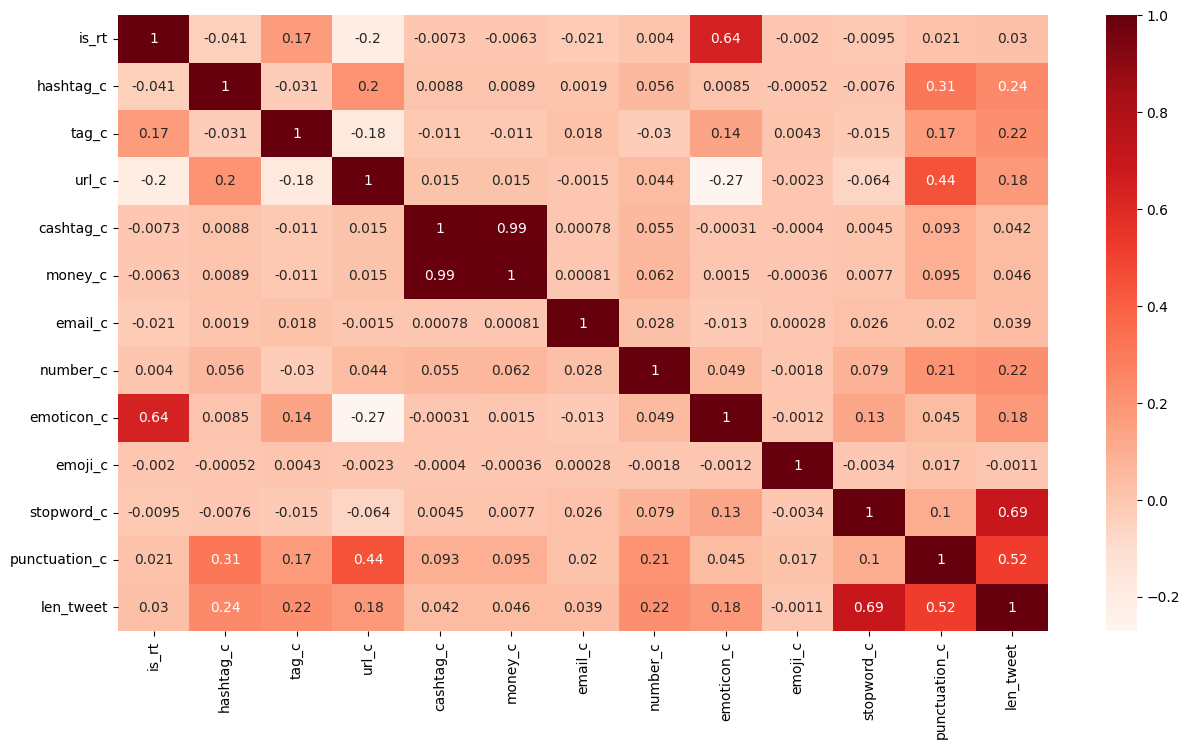

In [45]:
plt.figure(figsize=(15,8))
cor = singletweet_features_df.corr(numeric_only=True)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

There are two observations to be made:
- as we can see, none of the features is really relevant for the classification task
- some features are highly correlated between them ('number_c', 'stopwords_c', 'punct_c'), so they were discarded from the dataset

In [48]:
from sklearn.feature_selection import SelectKBest, f_classif


# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

0 -> is_rt: 26154.320
1 -> url_c: 1139.287
2 -> tag_c: 5765.943
3 -> hashtag_c: 4154.838
4 -> cashtag_c: 510.135
5 -> money_c: 569.902
6 -> email_c: 49.479
7 -> emoji_c: 1.674
8 -> emoticon_c: 8910.102
9 -> len_tweet: 686.963


<Figure size 3000x1000 with 0 Axes>

<BarContainer object of 10 artists>

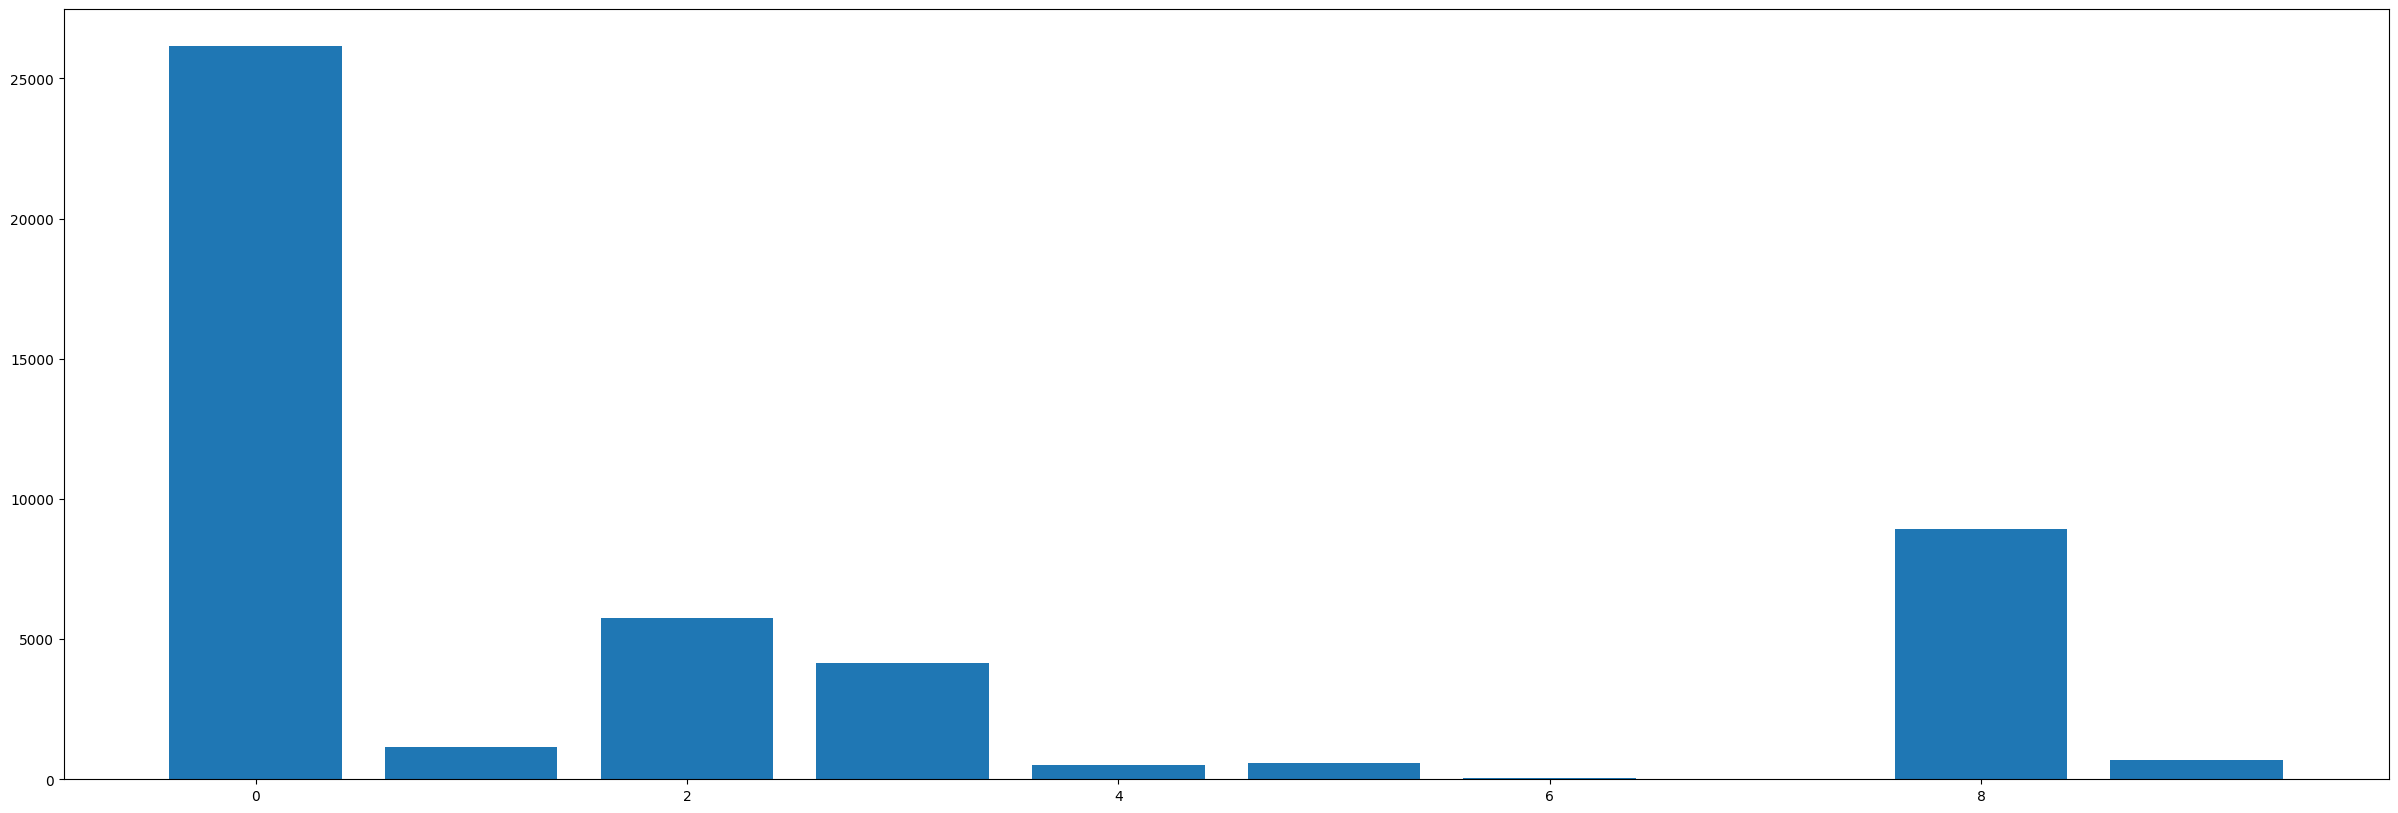

In [50]:
feature_columns = ['is_rt','url_c','tag_c','hashtag_c','cashtag_c','money_c','email_c','emoji_c','emoticon_c','len_tweet']
train_ds = singletweet_features_df[singletweet_features_df['split'] == 'train'].reset_index(drop=True)
val_ds = singletweet_features_df[singletweet_features_df['split'] == 'val'].reset_index(drop=True)
test_ds = singletweet_features_df[singletweet_features_df['split'] == 'test'].reset_index(drop=True)

X_train = train_ds[feature_columns]
y_train = train_ds['label']

X_test = val_ds[feature_columns]
y_test = val_ds['label']

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print(f'{i} -> {feature_columns[i]}: {fs.scores_[i]:.3f}')
# plot the scores

plt.figure(figsize=(30,10))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

The histogram shows that 'is_rt' feature (Is retweet? Yes/No) is highly correlated with the target label (Bot/Human). 

So we can further analyze the difference in percentages between retweets produced by bots and new posts.

In [51]:
num_rt_bot = singletweet_features_df[(singletweet_features_df['is_rt'] == 1.0) & (singletweet_features_df['label'] == 1.0)].shape[0]
num_nort_bot = singletweet_features_df[(singletweet_features_df['is_rt'] == 0.0) & (singletweet_features_df['label'] == 1.0)].shape[0]
num_tweets = singletweet_features_df.shape[0]
print(f'Number of tweets from bots which are retweet: {num_rt_bot} - ({num_rt_bot/num_tweets*100:.1f}%)')
print(f'Number of tweets from bots which are not retweet: {num_nort_bot} - ({num_nort_bot/num_tweets*100:.1f}%)\n')

num_rt_human = singletweet_features_df[(singletweet_features_df['is_rt'] == 1.0) & (singletweet_features_df['label'] == 0.0)].shape[0]
num_nort_human = singletweet_features_df[(singletweet_features_df['is_rt'] == 0.0) & (singletweet_features_df['label'] == 0.0)].shape[0]
print(f'Number of tweets from humans which are retweet: {num_rt_human} - ({num_rt_human/num_tweets*100:.1f}%)')
print(f'Number of tweets from humans which are not retweet: {num_nort_human} - ({num_nort_human/num_tweets*100:.1f}%)\n')

print(f"Pearson Correlation:\n{singletweet_features_df[['is_rt','label']].corr()}")

Number of tweets from bots which are retweet: 14636 - (0.8%)
Number of tweets from bots which are not retweet: 20284 - (1.2%)

Number of tweets from humans which are retweet: 30709 - (1.8%)
Number of tweets from humans which are not retweet: 79163 - (4.5%)

Pearson Correlation:
       is_rt
is_rt    1.0


C:\Users\SAKSHI PATIL\AppData\Local\Temp\ipykernel_8168\503316706.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f"Pearson Correlation:\n{singletweet_features_df[['is_rt','label']].corr()}")


Therefore, if the tweet is a retweet the probability that the account is a bot is twice.

We can perform the same analysis on the 'cashtag_c' feature, which indicates the number of cashtags per tweet and which is poorly correlated with the target label.

In [53]:
print(f"Pearson Correlation:\n{singletweet_features_df[['cashtag_c','label']].corr(numeric_only=True)}")

Pearson Correlation:
           cashtag_c
cashtag_c        1.0


Finally, we can compare the average number of URLs per tweet for bot and human users with the corresponding average of hashtags.

In [54]:
mean_url_bot = singletweet_features_df[singletweet_features_df['label'] == 1.0]['url_c'].mean()
mean_url_nobot = singletweet_features_df[singletweet_features_df['label'] == 0.0]['url_c'].mean()
print(f"Average z-score of URLs per single tweet by bot user: {mean_url_bot:.3f}")
print(f"Average z-score of URLs per single tweet by human user: {mean_url_nobot:.3f}")
print(f"Difference: {abs(mean_url_bot - mean_url_nobot):.3f}")

Average z-score of URLs per single tweet by bot user: 0.563
Average z-score of URLs per single tweet by human user: 0.418
Difference: 0.145


In [55]:
mean_hashtag_bot = singletweet_features_df[singletweet_features_df['label'] == 1.0]['hashtag_c'].mean()
mean_hashtag_nobot = singletweet_features_df[singletweet_features_df['label'] == 0.0]['hashtag_c'].mean()
print(f"Average z-score of hashtags per single tweet by bot user: {mean_hashtag_bot:.3f}")
print(f"Average z-score of hashtags per single tweet by human user: {mean_hashtag_nobot:.3f}")
print(f"Difference: {abs(mean_hashtag_bot - mean_hashtag_nobot):.3f}")

Average z-score of hashtags per single tweet by bot user: 0.529
Average z-score of hashtags per single tweet by human user: 0.300
Difference: 0.229


The difference between z-scores for hashtags count is almost twice the one for URLs.

In order for these features to be suitable for constituting a vector of values passed directly to a linear layer, they should be normalized. In fact, NN can have a hard time dealing with "very different" scales, since some of the inputs can have a greater influence in the final results, with an imbalance not due to the intrinsic nature of the data but simply to their original measurement scales. For this reason we apply the zscore normalization to all input features besides text obviously.

## **TASK 3: Text from Multiple Tweets + Statistical Features**
Since in the dataset we have multiple tweets for the same user, it makes sense to use them. Even though we have to give up the possibility to detect a bot just from a single tweet, we gain a lot of information to analyze, both from the actual text of the tweets, and from the features that now become more relevant since they can have more statistical relevance. 

The architecture that we use is really the same as for the previous step, but the LSTM take in the embedding vector derived from the concatenation of multiple tweets (we used 20) and the subsequent linear layer uses a different set of features. 

Regarding these features we use : 
- avg_length: Average length of tweets per account (from *"Detecting Social Bots on Twitter: A Literature Review"*)
- avg_cleaned_length: Average length of tweets without 'retweet', 'username', 'hashtag', 'url', 'emoticon', 'emoji','number', 'stock', 'money' and 'email' keywords (from *"Detecting Social Bots on Twitter: A Literature Review"*)
- 1+_mention: Count of tweets per account with at least one mention
- 1+_emot: Count of tweets per account with at least one emoticon
- 1+_url: Count of tweets per account with at least one URL
- max_hashtag: Maximum number of hashtags in a single tweet (from *"Identifying Automatic Posting Systems in Microblogs"*)
- max_mentions: Maximum number of tags in a single tweet
- unique_words_ratio: Ratio between n° of unique words in a tweet and n° of words in the same tweet (from *"You Are Known by Your Friends: Leveraging Network Metrics for Bot Detection in Twitter"*)
- url_count: Count of URLs using all the tweets per account (*"Feature selection using Principal Component Analysis for massive retweet detection"*)
- hashtag_count: Count of hashtags using all the tweets per account (from *"Identifying Automatic Posting Systems in Microblogs"*)
- unique_hashtag_ratio: Ratio between n° of unique hashtags in a tweet and n° of hashtags in the same tweet (from *"Identifying Automatic Posting Systems in Microblogs"*)
- mention_count: Count of tags using all the tweets per account (from *"Identifying Automatic Posting Systems in Microblogs"*)
- unique_mention_ratio: Ratio between n° of unique tags in a tweet and n° of tags in the same tweet (from *"Identifying Automatic Posting Systems in Microblogs"*)
- emot_count: Count of emoticons using all the tweets per account (from *"Hybrid feature selection approach to identify optimal features of profile metadata to detect social bots in Twitter"*)
- punct_count: Count of punctuation using all the tweets per account (from *""Detecting Social Bots on Twitter: A Literature Review""*)
- ?!_count: Count of '?' and '!' using all the tweets per account (from *"Detecting Social Bots on Twitter: A Literature Review"*)
- uppercased_count: Count of uppercased letters using all the tweets per account (from *"Deep neural networks for bot detection"*)
- cash_money_count: Count of words containing 'stock' and 'money' using all the tweets per account (from *"Detecting Social Bots on Twitter: A Literature Review"*)
- rt_count: Count of retweets using all the tweets per account (from *"Bot-hunter: A Tiered Approach to Detecting & Characterizing Automated Activity on Twitter"*)
- unique_rt_ratio: Ratio between n° of unique retweets in a tweet and n° of retweets in the same tweet (from *"Bot-hunter: A Tiered Approach to Detecting & Characterizing Automated Activity on Twitter"*)

In [57]:
def extract_multitweet_features(user_tweets):
    features = {}

    # Calculate features
    features['avg_length'] = np.mean([len(tweet) for tweet in user_tweets])
    features['avg_cleaned_length'] = np.mean([len(re.sub(r'RT|@|#|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|\$|\£|\€|\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b|\b\d+\b|:\)|<3|…|😀', '', tweet)) for tweet in user_tweets])
    features['1+_mention'] = sum(['@' in tweet for tweet in user_tweets])
    features['1+_emot'] = sum([':)' in tweet or '<3' in tweet or '…' in tweet or '😀' in tweet for tweet in user_tweets])
    features['1+_url'] = sum([re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet) is not None for tweet in user_tweets])
    features['max_hashtag'] = max([tweet.count('#') for tweet in user_tweets])
    features['max_mentions'] = max([tweet.count('@') for tweet in user_tweets])
    features['unique_words_ratio'] = np.mean([len(set(tweet.split())) / len(tweet.split()) for tweet in user_tweets if len(tweet.split()) > 0])
    features['url_count'] = sum([tweet.count('http') for tweet in user_tweets])
    features['hashtag_count'] = sum([tweet.count('#') for tweet in user_tweets])
    features['unique_hashtag_ratio'] = np.mean([len(set(re.findall(r'#\w+', tweet))) / tweet.count('#') for tweet in user_tweets if tweet.count('#') > 0])
    features['mention_count'] = sum([tweet.count('@') for tweet in user_tweets])
    features['unique_mention_ratio'] = np.mean([len(set(re.findall(r'@\w+', tweet))) / tweet.count('@') for tweet in user_tweets if tweet.count('@') > 0])
    features['emot_count'] = sum([':)' in tweet or '<3' in tweet or '…' in tweet or '😀' in tweet for tweet in user_tweets])
    features['punct_count'] = sum([len(re.findall(r'[^\w\s]', tweet)) for tweet in user_tweets])
    features['?!_count'] = sum([tweet.count('?') + tweet.count('!') for tweet in user_tweets])
    features['uppercased_count'] = sum([len(re.findall(r'[A-Z]', tweet)) for tweet in user_tweets])
    features['cash_money_count'] = sum([tweet.count('stock') + tweet.count('money') for tweet in user_tweets])
    features['rt_count'] = sum([tweet.startswith('RT') for tweet in user_tweets])
    features['unique_rt_ratio'] = len(set([tweet for tweet in user_tweets if tweet.startswith('RT')])) / features['rt_count'] if features['rt_count'] > 0 else 0

    return features

In [59]:
tweets_df['features'] = tweets_df['tweet'].apply(extract_multitweet_features)

# Convert the 'features' column into separate columns
features_df = tweets_df['features'].apply(pd.Series)

# Concatenate the original DataFrame with the new DataFrame of features
tweets_df = pd.concat([tweets_df, features_df], axis=1)

# Save the DataFrame
tweets_df.to_pickle(ut.DATA_FOLDER / 'processed_dataset_v3.pkl')

C:\Users\SAKSHI PATIL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


KeyboardInterrupt: 

In [ ]:
multitweet_features_df = pd.read_pickle(ut.DATA_FOLDER / 'processed_dataset_v3.pkl')
multitweet_features_df_train = multitweet_features_df[multitweet_features_df['split'] == 'train']
multitweet_features_df_train.head(3)

In [ ]:
multitweet_features_df[multitweet_features_df['split'] == 'train']
multitweet_features_df_train.head(3)

In [ ]:
plt.figure(figsize=(20,8))
cor = multitweet_features_df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
feature_columns = multitweet_features_df.columns.difference(
	['account_id','label','split','tweet','processed_tweet','n_processed_tweet','n_tweet']).tolist()
train_ds = multitweet_features_df[multitweet_features_df['split'] == 'train'].reset_index(drop=True)
val_ds = multitweet_features_df[multitweet_features_df['split'] == 'val'].reset_index(drop=True)
test_ds = multitweet_features_df[multitweet_features_df['split'] == 'test'].reset_index(drop=True)

X_train = train_ds[feature_columns]
y_train = train_ds['label']

X_test = val_ds[feature_columns]
y_test = val_ds['label']

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print(f'{i} -> {feature_columns[i]}: {fs.scores_[i]:.3f}')
# plot the scores

plt.figure(figsize=(30,10))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Analysis about number of retweets per account:

In [ ]:
NUM_TW_FEATURES = 30
NUM_TW_TXT = 10

def retweet_count(proc_sentence : list):
    return proc_sentence.count('retweet')

df = cleaned_df.copy(deep=True)

# AGGREGATE TWEET FROM SAME ACCOUNT 
aggregation_functions = {'account_id': 'first', 'tweet': lambda x : x.tolist(), 'label': 'first', 'split': 'first','processed_tweet': lambda x : x.tolist()}
df = df.groupby(df['account_id'],as_index=False,sort=False).agg(aggregation_functions) 
df = df[df['tweet'].map(lambda x: len(x)) >= NUM_TW_FEATURES].reset_index(drop=True)
df['n_processed_tweet'] = df['processed_tweet'].map(lambda x: x[:NUM_TW_FEATURES]).apply(lambda x : list(flatten(x)))
df['rt_count'] = df['n_processed_tweet'].apply(retweet_count)

In [ ]:
mean_rt_bot = df[df['label'] == 1.0]['rt_count'].mean()
mean_rt_nobot = df[df['label'] == 0.0]['rt_count'].mean()
mean_rt = df['rt_count'].mean()
print(f"Average number of retweets: {mean_rt:.3f}")
print(f"Average number of retweets by bot users: {mean_rt_bot:.3f} (+{(mean_rt_bot-mean_rt)/mean_rt*100:.3f}%)")
print(f"Average number of retweets by human users: {mean_rt_nobot:.3f} ({(mean_rt_nobot-mean_rt)/mean_rt*100:.3f}%)")
print(f"Pearson Correlation:\n{multitweet_features_df[['rt_count','label']].corr()}")

Analysis on unique words per account:

In [ ]:
nltk.download('stopwords',ut.DATA_FOLDER)

sw = stopwords.words('english')

def clean_tweet(tweet: list ):
        to_remove = ['retweet','username','hashtag','url','emoticon','emoji','number','stock','money','email']
        return [x for x in tweet if x not in to_remove and x not in punctuation and x not in sw]

def unique_words_ratio(sentence_list : list[list]):
    s = []
    for sentence in sentence_list:
        if sentence[0] != 'retweet':
            s.extend(clean_tweet(sentence))
    
    if s : return len(set(s)) / len(s)
    else : return 1.0

df['unique_words_ratio'] = df['n_processed_tweet'].apply(unique_words_ratio)

In [ ]:
mean_unique_words_bot = df[df['label'] == 1.0]['unique_words_ratio'].mean()
mean_unique_words_nobot = df[df['label'] == 0.0]['unique_words_ratio'].mean()
mean_unique_words = df['unique_words_ratio'].mean()
print(f"Average unique words used by each account in general: {mean_unique_words:.3f}")
print(f"Average unique words used by each bot: {mean_unique_words_bot:.3f} ({(mean_unique_words_bot-mean_unique_words)/mean_unique_words*100:.3f}%)")
print(f"Average unique words used by each human: {mean_unique_words_nobot:.3f} (+{(mean_unique_words_nobot-mean_unique_words)/mean_unique_words*100:.3f}%)")
print(f"Pearson Correlation:\n{multitweet_features_df[['unique_words_ratio','label']].corr()}")

Here is an example of a user with an low score on 'unique_words_ratio' feature:

In [ ]:
df.loc[df['unique_words_ratio'].idxmin(),'tweet'][:3]

Here is an example of a user with an high score on 'unique_words_ratio' feature:

In [ ]:
df.loc[df['unique_words_ratio'][:100].idxmax(),'tweet'][:10]

## **Account level**
As can be seen from the results, text alone, although with the addition of other features, is not enough. We can therefore use general account user-data, which are present in the dataset. 

Same as before, we developed a set of custom features from account-user data, that we passed to yet another linear layer which is added to the previous model architecture.

- Features used:
    
    According to paper *"BotSpot: Deep Learning Classification of Bot Accounts Within Twitter"* recent studies show that similar high performance can be achieved by using a minimal number of features, for this reason we decided to use only 21 features and leave the Random Forest to choose the most relevant ones. This approach ensures model efficiency and interpretability (a limited set of features with a clear meaning, like the ones provided by account metadata, allows to produce interpretable models).
    
    *"TweezBot: An AI-Driven Online Media Bot Identification Algorithm for Twitter Social Networks"* finds a strong correlation between **verification status**, **listed count**, **number of friends and followers**, and **default profile**, with respect to the target classification variable. 
    In particular, about the **followers/following features**, bot profiles often indulge in buying followers from online black-marketeers to mimic an influential public status. In Twitter, friends are the specific users that a certain user may choose to follow (i.e., following). In the case of bots, the friend count has a concentration towards the bottom, indicating a low following, whereas there is a uniform ratio in the case of non-bots as the number of followers are not exorbitantly high, with friends being relatively uniform till a certain degree. A key observation was found that bots do not experience an increase in their follower count even when they are posting more and staying extremely active, as a part of their attempt to mimic natural behavior. Meanwhile, for the non-bots, the follower count increases till a certain rate for a number of statuses.
    On the other hand, **listed count feature** indicates the number of public lists that this user is a member of. They find how the non-bots have clearly been added to a number of lists, leading to the increase in the listed count feature, while bots have not added to many lists because of their suspicious nature and lack of credibility, though some bots might also often show non-malicious behavior.
    Finally, bot users often try to conceal their personal information. This is apparent from the fact that the profile-based parameters for bots are missing. This indicates collusion in the online social network caused by such suspicious users. A smaller amount of information on the public domain actually helps these bots to rapidly disappear after fraudulent indulgence. In particular, the most common missing features for bots are: **location** (present or not), **description** (present or not), **url** (present or not) and **verified account** (yes or no).

    In another paper, *"Detecting Social Bots on Twitter: A Literature Review"*, authors computed 20 from the most common features as input to their model. They identify the social connections of users and ranking through performing content and behavioral analysis. For example, if an **account is verified** or protected, it is a logical indicator that it is a human account, not a bot account. The profile features that are extracted from the metadata, such as **profile image**, **screen name**, and **description**, may also indicate the nature of the account. For example, a **default profile image** is a sign of a new user or a bot account. The temporal pattern, such as the **average of tweeting ratios**, for example, can be a sign of bot activity if it occurs with small inter-arrivals. Therefore, using an entropy component to detect behavior as part of the classification system is essential. In addition, the rate of **posting similar content** with URL can be an indicator of a spammer. In other words, the **URL feature** can be used to detect the link farming behavior that is typically employed by spammers and bot accounts. Also, using the **mention feature** in association with the URL and number of link feature and entropy of tweets can indicate a bot account with malicious intention. Moreover, if the **number of followers** is high yet the account is relatively new, it’s likely that the followers are fake and the account is a bot.

    Finally, paper *"Language-Agnostic Twitter Bot Detection"* makes use of **Levenshtein distance** to detect similar posts for their classification approach. They observed that bot accounts tend to choose user names and screen names that are similar, while humans can be more creative in this respect. The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits required to change one word into the other.

- Account verification feature: 

    We noted that **'is_verified'** is the most relevant feature for the Random Forest model, but it has also a bias on it. Indeed, using only this feature for classification produces an accuracy of 81%, which is competitive with the best results obtained by the other papers. Though, this behaviour is unrealistic because in reality the number of unverified non-bot users is significantly higher than the number of verified ones. So the model can determine if an account is lead by a human if it is verified, but certainly not the other way around:
    - 'is_verified': False & 'label': 0 (no bot) -> tot: 1538, perc: 18.7036%
    - 'is_verified': True & 'label': 0 (no bot) -> tot: 2054, perc: 24.9787%
    - 'is_verified': False & 'label': 1 (bot) -> tot: 4630, perc: 56.3054%
    - 'is_verified': True & 'label': 1 (bot) -> tot: 1, perc: 0.0121%

    Therefore, to use this feature for classification Twibot-20 dataset is a hack that yields unrealistically high results. So we decided not to use the 'is_verified' feature as input, despite the fact that all other papers use it, and still obtain results comparable to ours. 


In [ ]:
account_df = process_account_dataset(account_df,False)
account_df_train = account_df[account_df['split'] == 'train']

median_fofo_bot = account_df_train[account_df_train['label'] == 1.0]['fofo_ratio'].median()
median_fofo_nobot = account_df_train[account_df_train['label'] == 0.0]['fofo_ratio'].median()
median_fofo = account_df_train['fofo_ratio'].median()
print(f"Median followers/following ratio per account: {median_fofo:.3f}")
print(f"Median followers/following ratio per bot account: {median_fofo_bot:.3f} ({(median_fofo_bot-median_fofo)/median_fofo*100:.3f}%)")
print(f"Median followers/following ratio per human account: {median_fofo_nobot:.3f} (+{(median_fofo_nobot-median_fofo)/median_fofo*100:.3f}%)")

In [ ]:
print(f'Followers/following ratio of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'fofo_ratio']]
print(f'Followers/following ratio of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'fofo_ratio']]

There are instead some features not so relevant, which are:
- 'def_profile': default profile
- 'num_in_screen_name': numbers in screen name
- 'has_location': location enabled by the user

Let's see them:

In [ ]:
print(f'Default profile feature of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'def_profile']]
print(f'Default profile feature of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'def_profile']]

In [ ]:
print(f'Numbers in screen name of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'num_in_screen_name']]
print(f'Numbers in screen name of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'num_in_screen_name']]

In [ ]:
print(f'Location enabled of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'has_location']]
print(f'Location enabled of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'has_location']]

Further considerations:
- Regularization: all the models, in particular those using a lot of features, are most prone to overfitting. For this reason, we decided to use Dropout and Weight Decay techniques to reduce its impact.
- Class imbalance: although the dataset already contains a balanced number of examples of the two classes, we noticed a small overrepresentation of the bot class, so we decided to use a weighted loss which takes into account the ratio between the two classes.

#### Random Forest
Given the tabular nature of the data available, the natural choice for this classification task would be to use a Random Forest. We decided to experiment with this model to investigate its performance, without the possibility to use the text from tweets though. The reason is that add account features in input to the previous model has improve further the results. 

In [ ]:
NUM_ESTIMATORS = 100
CLASS_WEIGHT = 'balanced'
RND_STATE = 18

train = account_df[account_df['split'] == 'train'].reset_index(drop=True)
val = account_df[account_df['split'] == 'val'].reset_index(drop=True)
test = account_df[account_df['split'] == 'test'].reset_index(drop=True)

X_train, y_train = train.drop(columns=["account_id", "label", "split"], axis=1), train["label"]
X_val, y_val = val.drop(columns=["account_id", "label", "split"], axis=1), val["label"]
X_test, y_test = test.drop(columns=["account_id", "label", "split"], axis=1), test["label"]

rf = RandomForestClassifier(n_estimators=NUM_ESTIMATORS, class_weight=CLASS_WEIGHT, random_state=RND_STATE)
rf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.barh(train.drop(columns=["account_id", "label", "split"], axis=1).columns, rf.feature_importances_)
plt.show()

## **Results**

| Model | Accuracy | Recall | F1-score |
| --- | --- | --- | --- |
| SingleTweet | 0.655 | 0.682 | 0.674 |
| SingleTweetAndMetadata | 0.656 | 0.682 | 0.676 |
| MultiTweetAndMetadata | 0.702 | 0.708 | 0.705 |
| TweetAndAccount | 0.733 | 0.729 | 0.730 |
| Random Forest | 0.762 | 0.886 | 0.801 |